In [25]:
import os
import matplotlib.pyplot as plt
import argparse
import numpy as np

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Embedding, LSTM, Dense, Conv2D, Flatten, Reshape, Add, Concatenate, MaxPool2D
from keras.models import Model, Sequential, load_model
from keras.optimizers import Adam
from keras import backend as K

from model.unet import unet, unet_small, dice_coef, normalized_iou_coef, hard_normalized_hard_iou_coef
from model.fcn import fcn_8s
from model.pspnet import pspnet50
from dataset_parser import generator_coarse, generator

from scripts import *

%load_ext autoreload
%autoreload 2

print('GPUs available:', K.tensorflow_backend._get_available_gpus())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
GPUs available: ['/job:localhost/replica:0/task:0/device:GPU:0']


# Clean Model

In [5]:
TRAIN_BATCH = int(4)
VAL_BATCH = int(4)
lr_init = 1e-4
lr_decay = 5e-4
vgg_path = None
TRAIN_N = 2975
VAL_N = 500

model_name = "modular_unet_clean_benchmark_other_metrics.h5"

labels = ['background', 'car', 'road']  # Use only 3 classes.
ignore_pedestrians=not('person' in labels)

clean_model = unet(input_shape=(256, 512, 3), num_classes=len(labels),
                    lr_init=lr_init, lr_decay=lr_decay, vgg_weight_path=vgg_path)

In [6]:
checkpoint = ModelCheckpoint(filepath=model_name,
                             monitor='val_dice_coef',
                             mode='max',
                             save_best_only=True,
                             save_weights_only=True)

In [7]:
history = clean_model.fit_generator(generator.data_generator('dataset_parser/data.h5', TRAIN_BATCH, 'train', ignore_pedestrians=ignore_pedestrians),
                                    steps_per_epoch= TRAIN_N // TRAIN_BATCH,
                                    validation_data=generator.data_generator('dataset_parser/data.h5', VAL_BATCH, 'val', ignore_pedestrians=ignore_pedestrians),
                                    validation_steps= VAL_N // VAL_BATCH,
                                    callbacks=[checkpoint],
                                    epochs=5, verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5
5002975
2975

500


743/743 [==============================] - 264s 355ms/step - loss: 0.2774 - dice_coef: 0.8387 - normalized_iou_coef: 0.6045 - hard_normalized_hard_iou_coef: 0.6926 - val_loss: 0.5238 - val_dice_coef: 0.7496 - val_normalized_iou_coef: 0.4518 - val_hard_normalized_hard_iou_coef: 0.5030
Epoch 2/5
743/743 [==============================] - 255s 343ms/step - loss: 0.1855 - dice_coef: 0.8947 - normalized_iou_coef: 0.7044 - hard_normalized_hard_iou_coef: 0.7855 - val_loss: 0.2206 - val_dice_coef: 0.8876 - val_normalized_iou_coef: 0.6809 - val_hard_normalized_hard_iou_coef: 0.7552
Epoch 3/5
743/743 [==============================] - 255s 343ms/step - loss: 0.1572 - dice_coef: 0.9120 - normalized_iou_coef: 0.7471 - hard_normalized_hard_iou_coef: 0.8210 - val_loss: 0.2317 - val_dice_coef: 0.8695 - val_normalized_iou_coef: 0.6565 - val_hard_normalized_hard_iou_coef: 0.7422

# Just Gold Data

In [58]:
TRAIN_BATCH = int(4)
VAL_BATCH = int(4)
lr_init = 1e-4
lr_decay = 5e-4
vgg_path = None
TRAIN_N = 2975
VAL_N = 500
CLEAN_N = 500

model_name = "modular_unet_gold_benchmark_other_metrics.h5"

labels = ['background', 'car', 'road']  # Use only 3 classes.
ignore_pedestrians=not('person' in labels)

gold_model = unet(input_shape=(256, 512, 3), num_classes=len(labels),
                    lr_init=lr_init, lr_decay=lr_decay, vgg_weight_path=vgg_path)

In [59]:
checkpoint = ModelCheckpoint(filepath=model_name,
                             monitor='val_dice_coef',
                             mode='max',
                             save_best_only=True,
                             save_weights_only=True)

In [62]:
fine_generator = generator.data_generator('dataset_parser/data.h5', TRAIN_BATCH, 'train', ignore_pedestrians=ignore_pedestrians)

history = gold_model.fit_generator(fine_generator,
                                   steps_per_epoch= CLEAN_N // TRAIN_BATCH,
                                   validation_data=generator.data_generator('dataset_parser/data.h5', VAL_BATCH, 'val', ignore_pedestrians=ignore_pedestrians),
                                   validation_steps= VAL_N // VAL_BATCH,
                                   callbacks=[checkpoint],
                                   epochs=5, verbose=1)

Epoch 1/5
500
500
2975
2975
125/125 [==============================] - 53s 427ms/step - loss: 0.4850 - dice_coef: 0.7126 - normalized_iou_coef: 0.4275 - hard_normalized_hard_iou_coef: 0.5034 - val_loss: 0.5004 - val_dice_coef: 0.7447 - val_normalized_iou_coef: 0.4767 - val_hard_normalized_hard_iou_coef: 0.5526
Epoch 2/5
125/125 [==============================] - 53s 424ms/step - loss: 0.3025 - dice_coef: 0.8178 - normalized_iou_coef: 0.5464 - hard_normalized_hard_iou_coef: 0.6481 - val_loss: 0.3787 - val_dice_coef: 0.8203 - val_normalized_iou_coef: 0.5552 - val_hard_normalized_hard_iou_coef: 0.6029
Epoch 3/5
125/125 [==============================] - 54s 434ms/step - loss: 0.2649 - dice_coef: 0.8478 - normalized_iou_coef: 0.6278 - hard_normalized_hard_iou_coef: 0.7232 - val_loss: 0.3191 - val_dice_coef: 0.8591 - val_normalized_iou_coef: 0.6332 - val_hard_normalized_hard_iou_coef: 0.6802
Epoch 4/5
125/125 [==============================] - 54s 436ms/step - loss: 0.2348 - dice_coef: 0.86

# Coarse Data

In [8]:
TRAIN_BATCH = int(4)
VAL_BATCH = int(4)
lr_init = 1e-4
lr_decay = 5e-4
vgg_path = None
TRAIN_N = 2975
VAL_N = 500

model_name = "modular_unet_coarse_benchmark_other_metrics.h5"

labels = ['background', 'car', 'road']  # Use only 3 classes.
ignore_pedestrians=not('person' in labels)

coarse_model = unet(input_shape=(256, 512, 3), num_classes=len(labels),
                    lr_init=lr_init, lr_decay=lr_decay, vgg_weight_path=vgg_path)

In [9]:
checkpoint = ModelCheckpoint(filepath=model_name,
                             monitor='val_dice_coef',
                             mode='max',                             
                             save_best_only=True,
                             save_weights_only=True)

In [10]:
history = coarse_model.fit_generator(generator_coarse.data_generator('dataset_parser/data-coarse.h5', TRAIN_BATCH, 'train_extra', ignore_pedestrians=ignore_pedestrians),
                                     steps_per_epoch= TRAIN_N // TRAIN_BATCH,
                                     validation_data=generator.data_generator('dataset_parser/data.h5', VAL_BATCH, 'val', ignore_pedestrians=ignore_pedestrians),
                                     validation_steps=VAL_N // VAL_BATCH,
                                     callbacks=[checkpoint],
                                     epochs=5, verbose=1)

Epoch 1/5
5000500
500

743/743 [==============================] - 263s 354ms/step - loss: 0.2697 - dice_coef: 0.8430 - normalized_iou_coef: 0.5563 - hard_normalized_hard_iou_coef: 0.6322 - val_loss: 0.4627 - val_dice_coef: 0.8011 - val_normalized_iou_coef: 0.4926 - val_hard_normalized_hard_iou_coef: 0.5189
Epoch 2/5
743/743 [==============================] - 257s 346ms/step - loss: 0.1642 - dice_coef: 0.9031 - normalized_iou_coef: 0.6647 - hard_normalized_hard_iou_coef: nan - val_loss: 0.4155 - val_dice_coef: 0.8227 - val_normalized_iou_coef: 0.5246 - val_hard_normalized_hard_iou_coef: 0.5384
Epoch 3/5
743/743 [==============================] - 257s 346ms/step - loss: 0.1746 - dice_coef: 0.8983 - normalized_iou_coef: 0.6878 - hard_normalized_hard_iou_coef: nan - val_loss: 0.2878 - val_dice_coef: 0.8643 - val_normalized_iou_coef: 0.6256 - val_hard_normalized_hard_iou_coef: 0.6738
Epoch 4/5
743/743 [==============================] - 257s 346ms/step - loss: 0.1273 - dice_coef: 0.9256 - no

# Manually measure metrics

In [11]:
# clean_model = unet(input_shape=(256, 512, 3), num_classes=len(labels),
#                    lr_init=lr_init, lr_decay=lr_decay, vgg_weight_path=vgg_path)

# clean_model.load_weights("modular_unet_clean_benchmark_other_metrics.h5")

2975
2975
2975
0
79706.06491084956 4893.056288530584 10031.935089588165
0.8422823123463471
1
2042.1028669904917 4407.085131105538 999.8971329331398
0.2741414322792622
2
34282.004311325494 5741.686477221929 4009.99568849802
0.7785404097201025

0
83278.0 2664.0 6460.0
0.9012575485379104
1
2436.0 543.0 606.0
0.6794979079497908
2
36211.0 5940.0 2081.0
0.8186606981370953

0
60495.90936887171 3678.374052395695 5085.09063065052
0.8734689014590721
1
23570.17389846407 2625.9836773977177 1546.8261014819145
0.8495904468167439
2
37734.797484052135 2966.7614813185473 2639.2025153636932
0.870653772449887

0
61313.0 1240.0 4268.0
0.9175708235434968
1
24764.0 1663.0 353.0
0.9247199402539208
2
39211.0 2881.0 1163.0
0.9065079181597503

0
56362.12185388245 5816.670996011817 6065.8781462311745
0.8258831207067052
1
28813.124680302106 3172.2134566636983 2348.8753198981285
0.839195711196405
2
33177.94027181552 3729.928667838463 4304.059729099274
0.8050567237094857

0
56925.0 1694.0 5503.0
0.8877608309160663


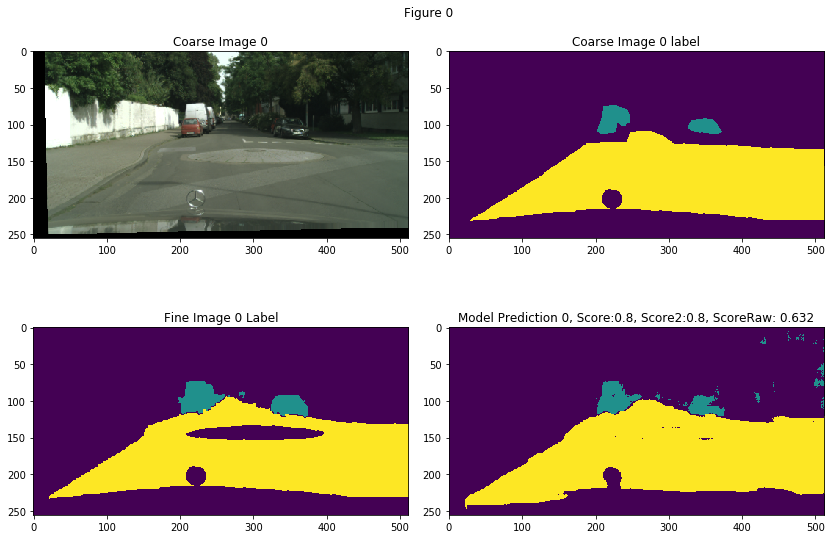

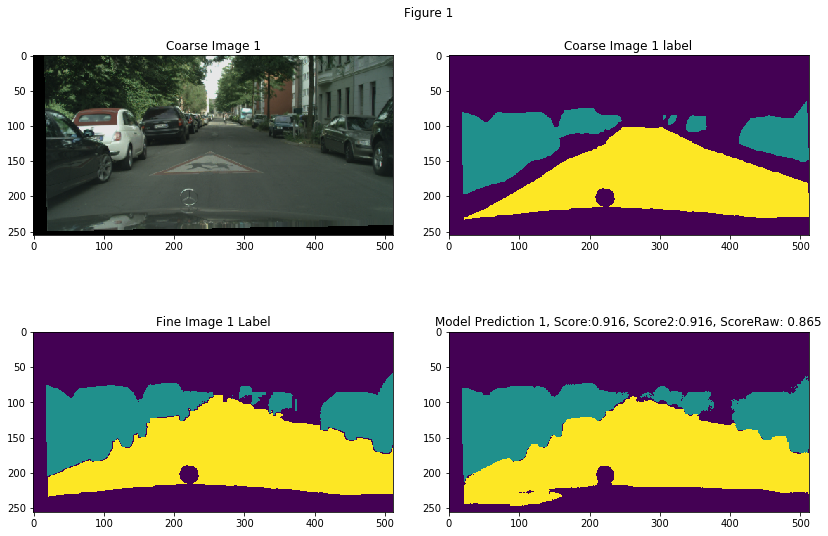

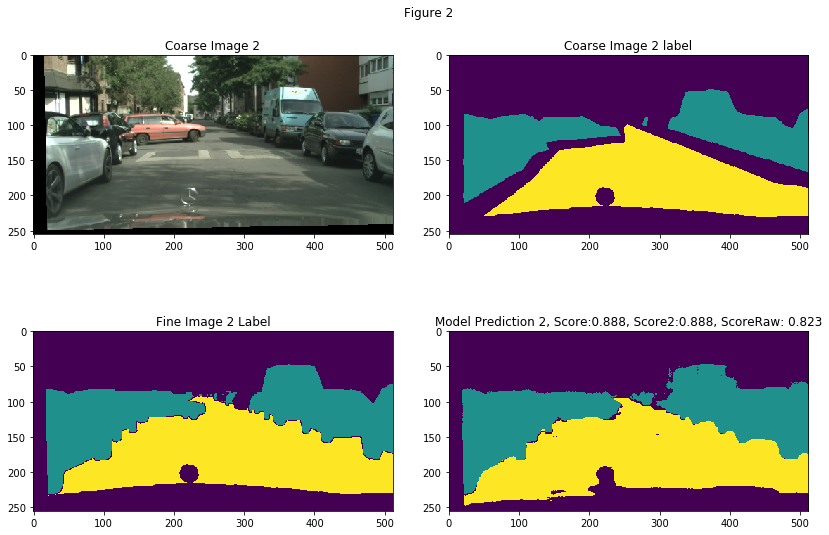

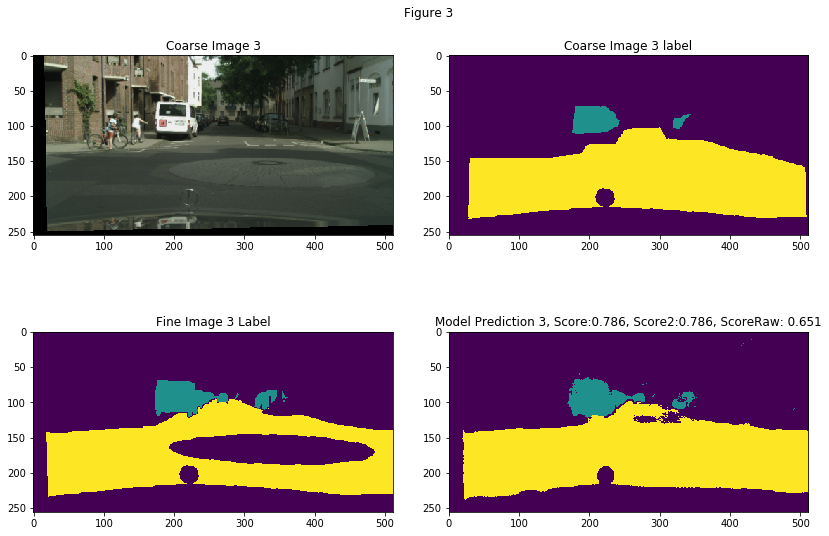

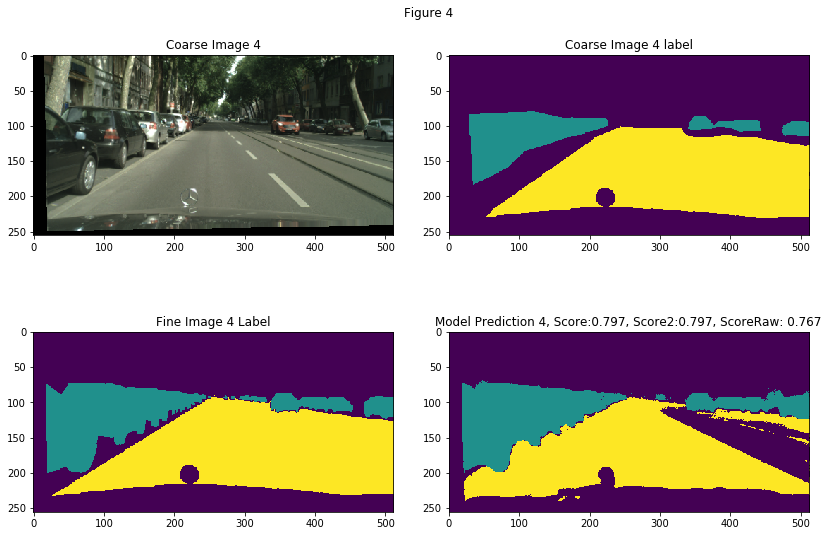

In [12]:
view_paired_predictions_on_training_data(clean_model, ignore_pedestrians=ignore_pedestrians)

2975
2975
2975
0
79305.19043941051 7946.500566746574 10432.809561133385
0.8118502933306264
1
1332.1015306023182 2163.844907137239 1709.8984681367874
0.2558857504760938
2
32024.769481387862 8299.59298278768 6267.230519115925
0.6873508165490818

0
80342.0 6250.0 9396.0
0.8370004583906322
1
1248.0 796.0 1794.0
0.3251693590411673
2
33836.0 8600.0 4456.0
0.7215729762006312

0
58982.73946291581 13904.27810723777 6598.260539472103
0.7420586662799006
1
17212.491970861243 461.79395379694506 7904.508027791977
0.6729203887743299
2
34254.315234757145 6256.381204522799 6119.684763371944
0.7345922197352547

0
58961.0 11246.0 6620.0
0.7674515469821808
1
18425.0 130.0 6692.0
0.7297896779815424
2
35791.0 6519.0 4583.0
0.7632482460068667

0
55489.4875645265 20706.62818528479 6938.512437224388
0.667465396485405
1
20706.50523647487 857.0084240703044 10455.494758665562
0.6466941438464846
2
26977.010920866283 6335.359589973785 10504.989078998566
0.6156694783389532

0
55421.0 17310.0 7007.0
0.695038751912513

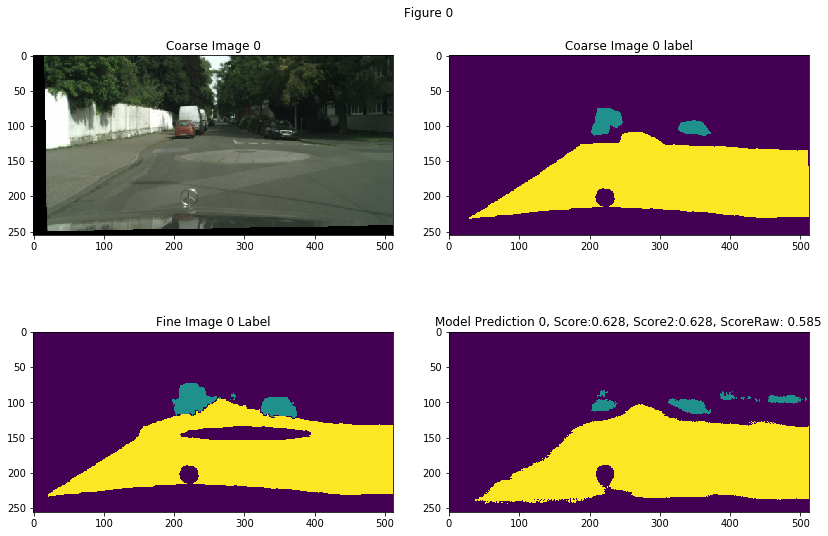

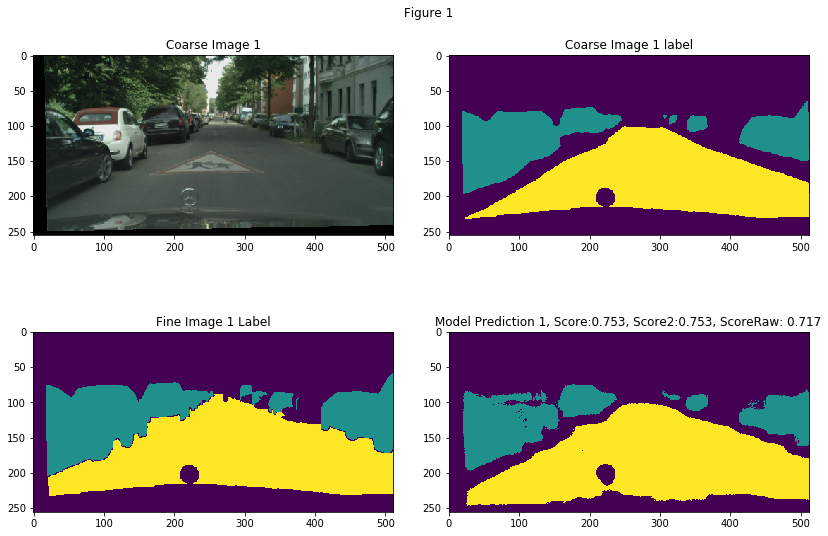

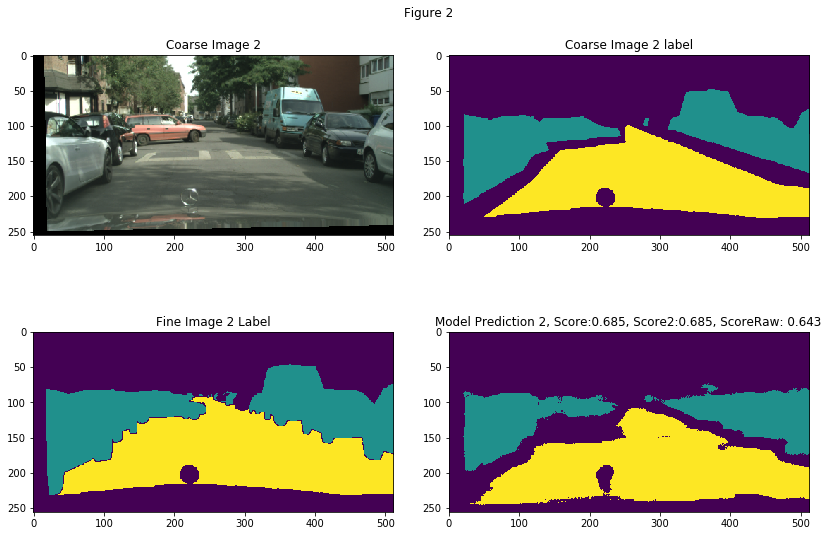

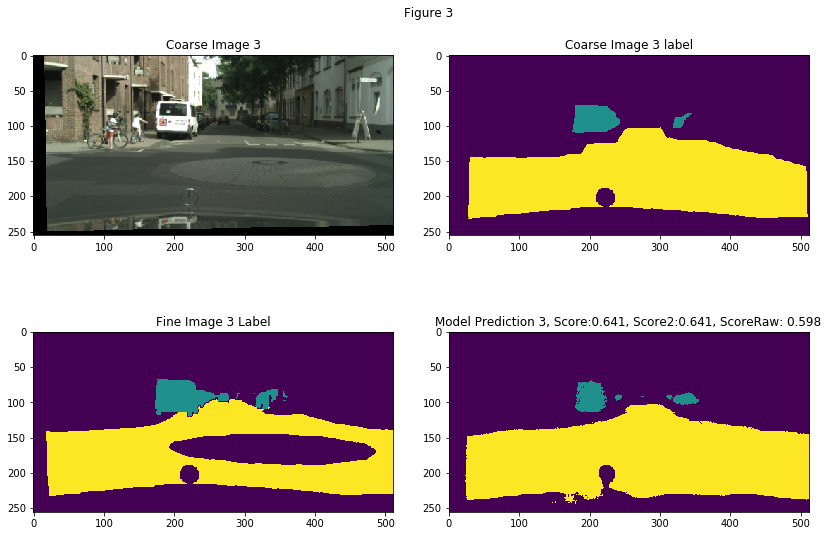

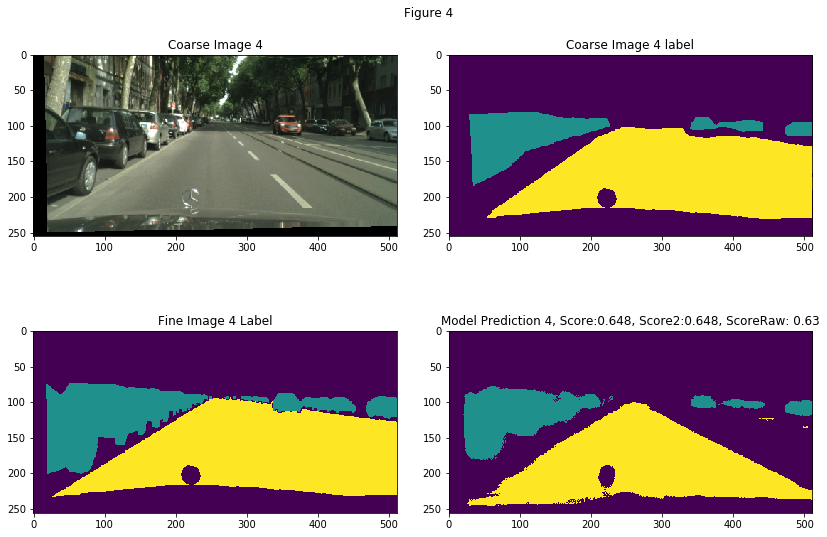

In [13]:
view_paired_predictions_on_training_data(coarse_model, ignore_pedestrians=ignore_pedestrians)

# Apply Error Correction Networks

In [26]:
from keras.layers import Input, Embedding, LSTM, Dense, Conv2D, Flatten, Reshape, Add, Concatenate, MaxPool2D, Lambda
from keras.models import Model, Sequential, load_model
from keras.optimizers import Adam
from keras import backend as K

input_window_size = 64
output_window_size = 1

# ec_model = get_ec_model(input_window_size, output_window_size, dice_coef=dice_coef)

lr_init = 1e-3
lr_decay = 5e-4

inp_y = Input(shape=(input_window_size, input_window_size, 3))
inp_x = Input(shape=(input_window_size, input_window_size, 3))

h = Concatenate()([inp_x, inp_y])
h = Conv2D(8, (4, 4), padding='same', activation='relu')(h)
h = MaxPool2D((2, 2), padding='same')(h)
h = Conv2D(8, (4, 4), padding='same', activation='relu')(h)
h = MaxPool2D((2, 2), padding='same')(h)
h = Conv2D(16, (4, 4), padding='same', activation='relu')(h)
h = Flatten()(h)
h = Dense(40, activation='relu')(h)
h = Dense(3, activation='softmax')(h)
h = Reshape((1, 1, 3))(h)
ec_model = Model(inputs=[inp_x, inp_y], outputs=h)

ec_model.summary()
metrics=[dice_coef, normalized_iou_coef, hard_normalized_hard_iou_coef]
ec_model.compile(optimizer=Adam(lr=lr_init, decay=lr_decay),
                 loss='categorical_crossentropy', metrics=metrics)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
concatenate_19 (Concatenate)    (None, 64, 64, 6)    0           input_17[0][0]                   
                                                                 input_16[0][0]                   
__________________________________________________________________________________________________
conv2d_46 (Conv2D)              (None, 64, 64, 8)    776         concatenate_19[0][0]             
__________

In [18]:
test_get_ec_batch()

Test 1 passed
Test 2 passed
Test 3 passed


In [28]:
y_p = ec_model.predict([x_val_batch, y_val_coarse_batch])

In [34]:
t = normalized_iou_coef(y_val_diff_batch, y_p)

In [36]:
y_val_diff_batch.shape

(20672, 1, 1, 3)

In [43]:
output_offset = (input_window_size - output_window_size) // 2

In [45]:
y_val_coarse_batch_ = [y_val_coarse_batch[i, output_offset:output_offset+1, output_offset:output_offset+1, :] for i in range(len(y_val_coarse_batch))]

In [48]:
y_val_coarse_batch_ = np.array(y_val_coarse_batch_)

In [50]:
np_hard_normalized_hard_iou_coef(y_val_diff_batch, y_p)

0.7321068340799949

In [35]:
K.eval(t)

0.6411255364092203

In [32]:
ec_model.evaluate([x_val_batch, y_val_coarse_batch], y_val_diff_batch)

20672/20672 [==============================] - 4s 191us/step


[0.2651333694401033, 0.8515819481836384, 0.4724625686742942, nan]

In [27]:
n_epochs = 20
batch_size = 8
skip = 12
N_CLEAN = 500
best_val = 0

val_generator = generator.data_generator('dataset_parser/data.h5', 32, 'val', ignore_pedestrians=True)

x_val, y_val = next(val_generator)
y_val_coarse = coarse_model.predict(x_val)
x_val_batch, y_val_coarse_batch, y_val_diff_batch = get_ec_batch(
    x_val, y_val, y_val_coarse, input_window_size=input_window_size,
    output_window_size=output_window_size, skip=skip, diff=False)

for e in range(n_epochs):
    fine_generator = generator.data_generator('dataset_parser/data.h5', batch_size, 'train', 
                                              ignore_pedestrians=ignore_pedestrians)
    for i in range(N_CLEAN // batch_size):
        x, y_fine = next(fine_generator)
        y_coarse = coarse_model.predict(x)
        x_batch, y_coarse_batch, y_diff_batch = get_ec_batch(x, y_fine, y_coarse, input_window_size=input_window_size,
                                                             output_window_size=output_window_size, skip=skip, diff=False,
                                                             balanced=True)
        
#         metrics = ec_model.train_on_batch(y_coarse_batch, y_diff_batch)
        metrics = ec_model.train_on_batch([x_batch, y_coarse_batch], y_diff_batch)  # x and y
        print(i, metrics)
    
#     metrics = ec_model.evaluate(y_val_coarse_batch, y_val_diff_batch)  # y only
    metrics = ec_model.evaluate([x_val_batch, y_val_coarse_batch], y_val_diff_batch)  # x and y 
    print('\nEpoch {}, batch {}, Validation metrics (loss, dice_coef, iou, hard_iou): {}'.format(e, i, metrics))
    if metrics[-1] > best_val:
        best_val = metrics[-1]
        ec_model.save('best-ec-model-5.h5')
        print('Model saved')

500
500
2975
2975
0 [1.1034076, 0.33336353, 0.18667218, 0.1521740592589091]
1 [0.89123946, 0.42544556, 0.23065875, 0.3838245859008995]
2 [1.0722383, 0.46675882, 0.23925343, 0.13715093672675857]
3 [0.7624346, 0.5023792, 0.2545735, 0.36391800888642045]
4 [0.82094246, 0.47877365, 0.26272127, 0.3570200877912234]
5 [0.739178, 0.5212613, 0.2808474, 0.3692552691206019]
6 [0.5928163, 0.5974324, 0.33228132, 0.46076126078526614]
7 [0.4971697, 0.6657006, 0.39040422, 0.5221837735687982]
8 [0.70125175, 0.6129892, 0.40081367, 0.4728895193132477]
9 [0.5212771, 0.6912665, 0.46870682, 0.5565970104879505]
10 [0.44245163, 0.72059935, 0.5070691, 0.6688785910817026]
11 [0.522513, 0.7050623, 0.46206152, 0.5810024889048939]
12 [0.50389874, 0.725757, 0.497236, 0.5796223921280171]
13 [0.5390151, 0.74812907, 0.5465043, 0.6582872835854168]
14 [0.41606176, 0.78818357, 0.5331371, 0.6023019482009366]
15 [0.46313965, 0.8223473, 0.5040153, 0.5452571500723895]
16 [0.3876581, 0.8233863, 0.57072747, 0.5936653752066179]


KeyboardInterrupt: 

2975
2975
2975


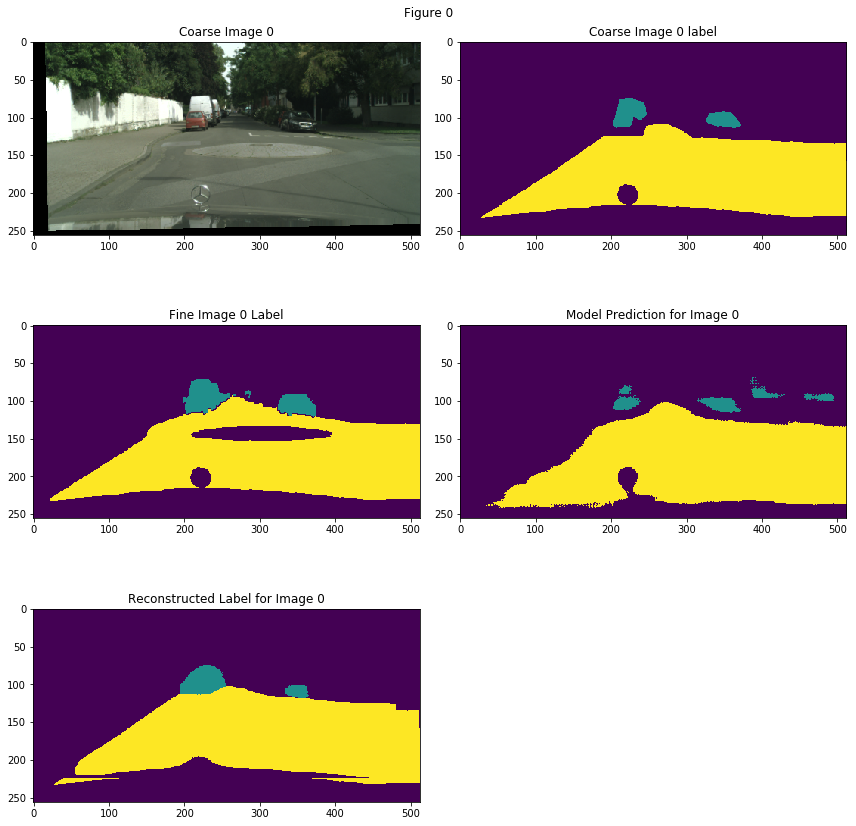

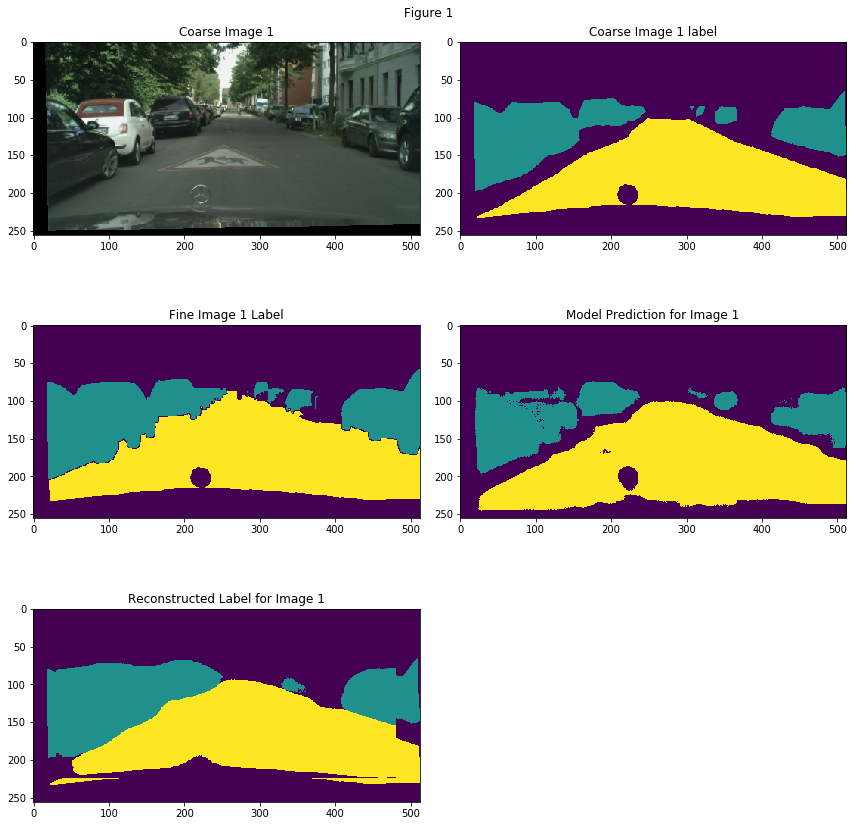

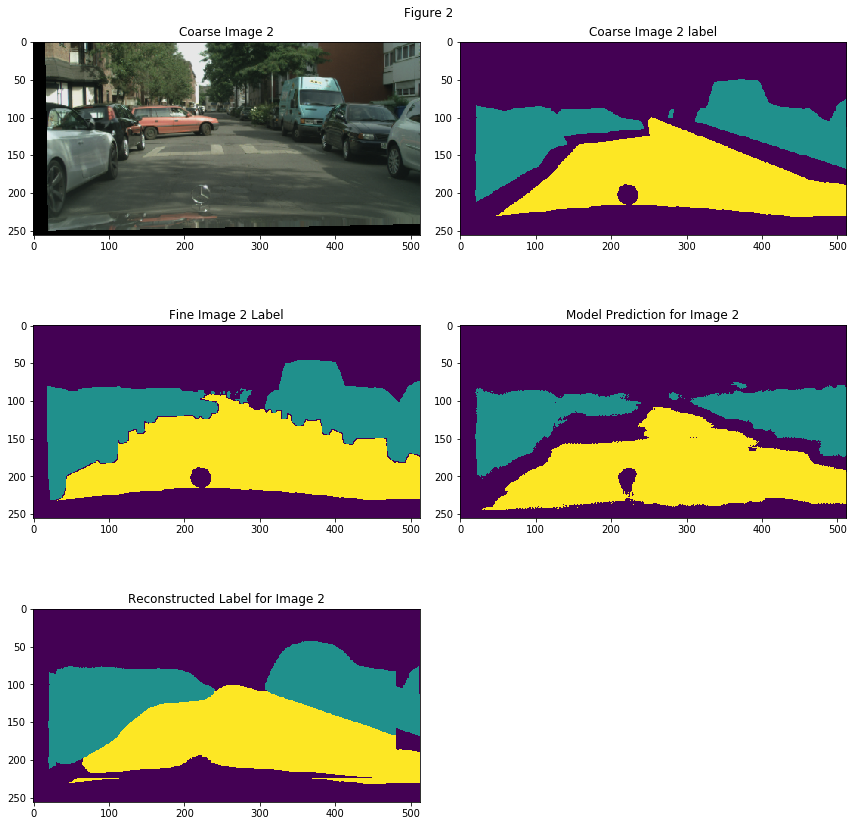

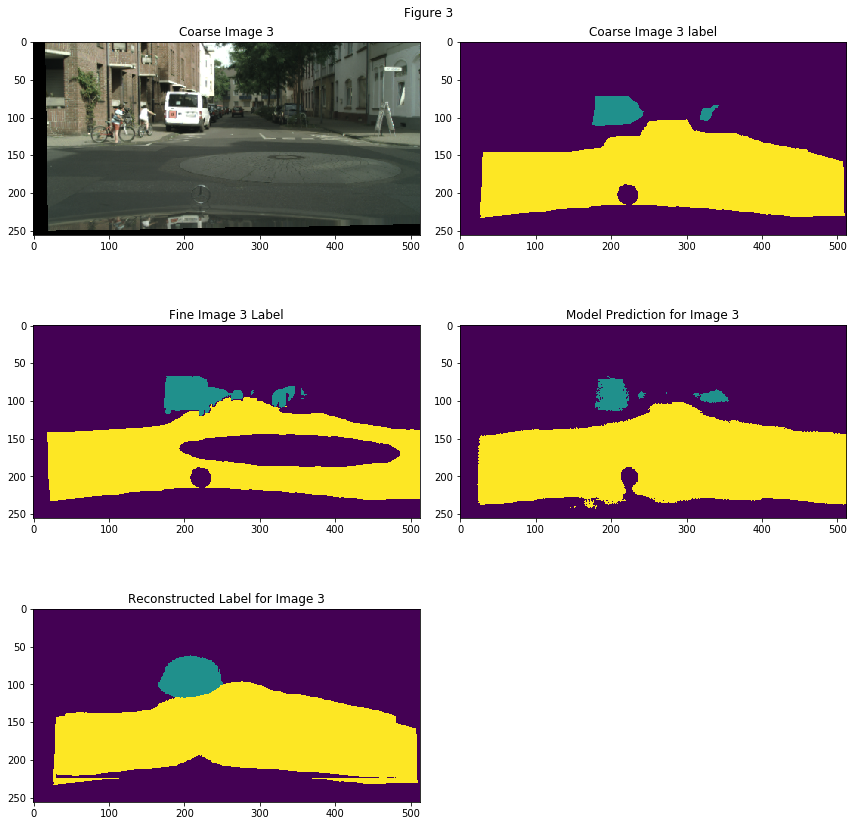

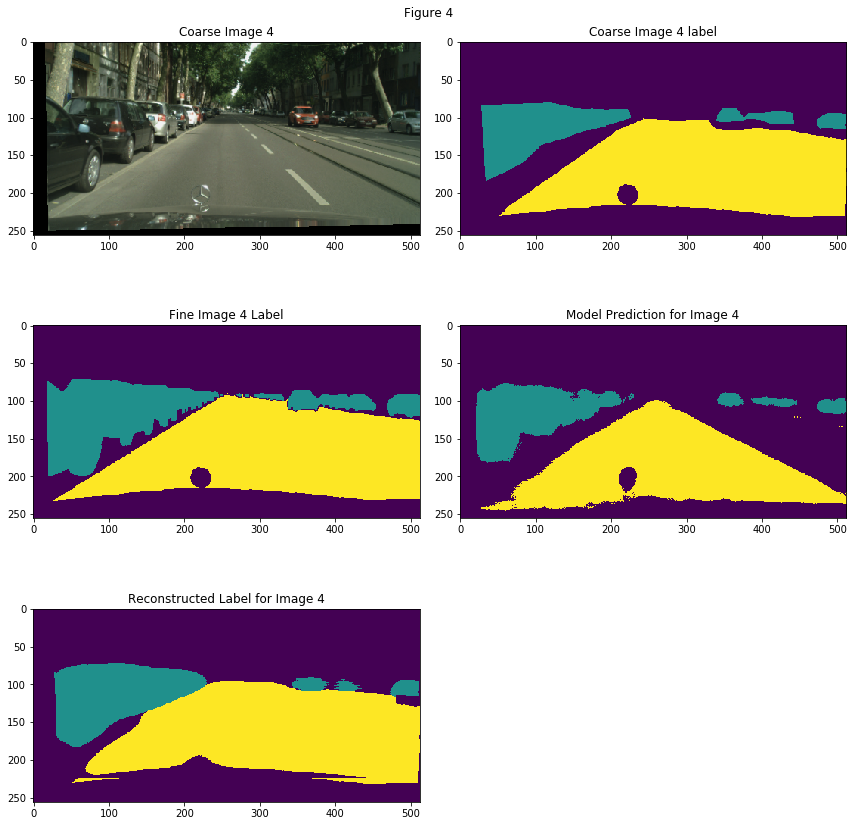

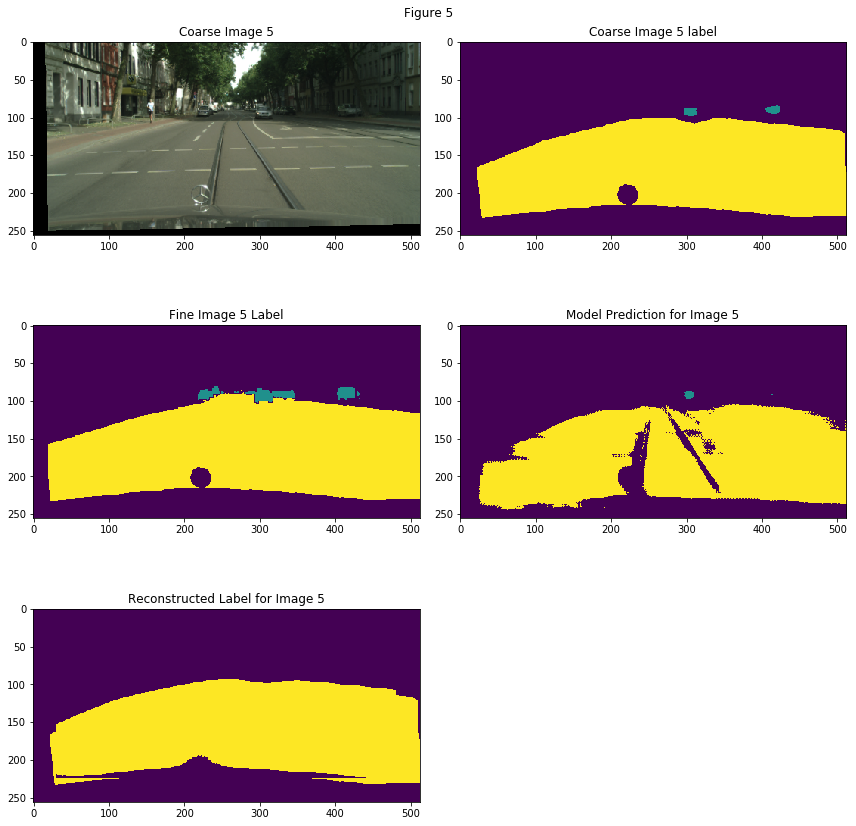

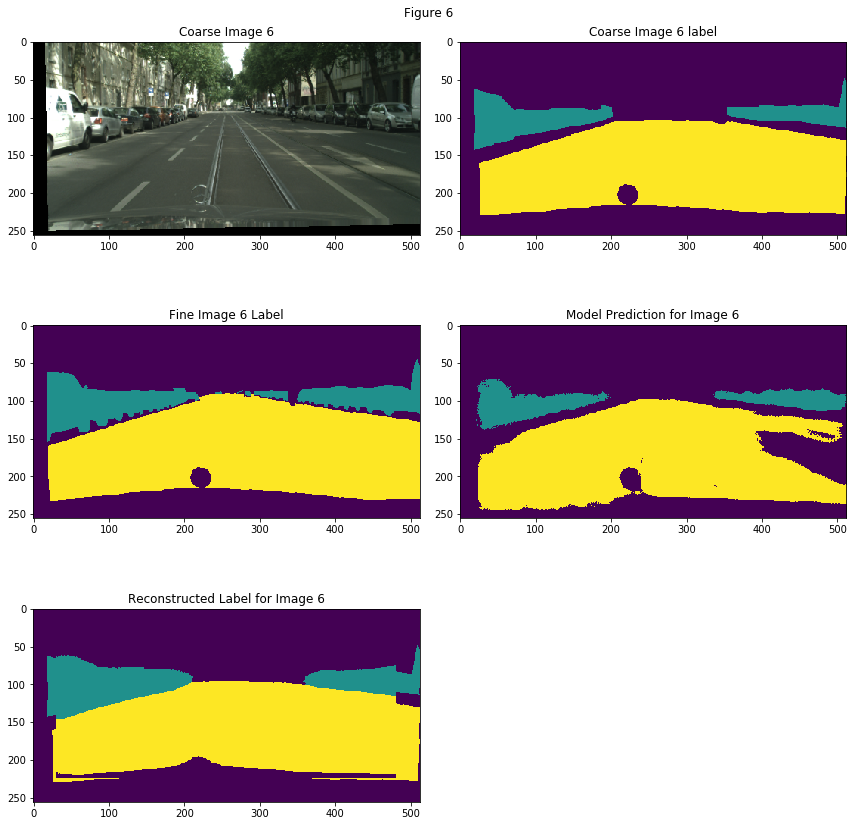

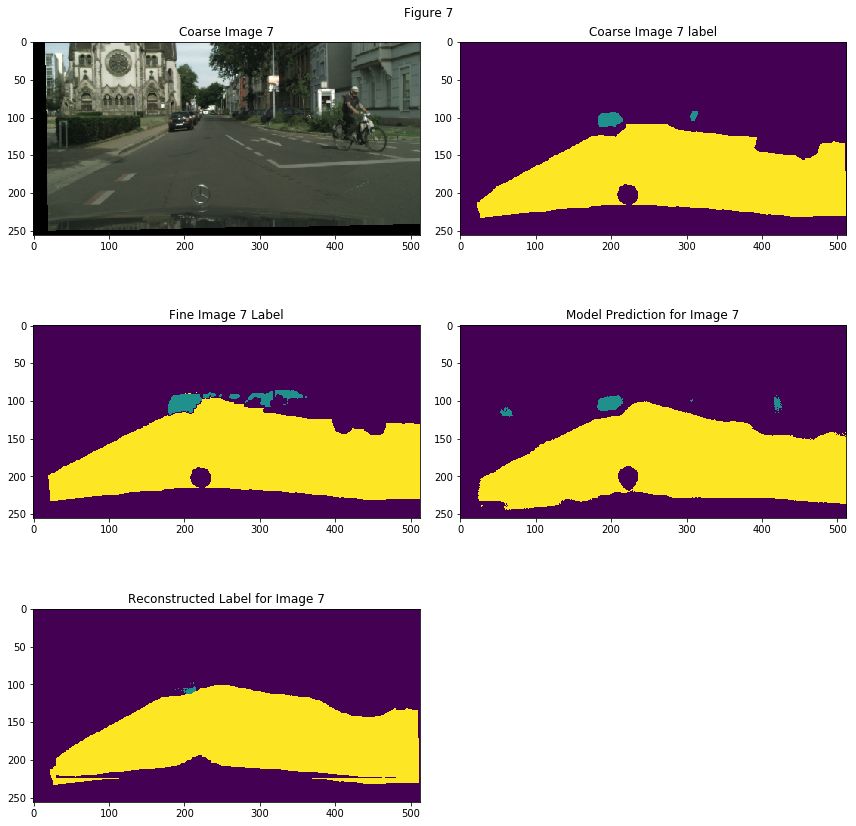

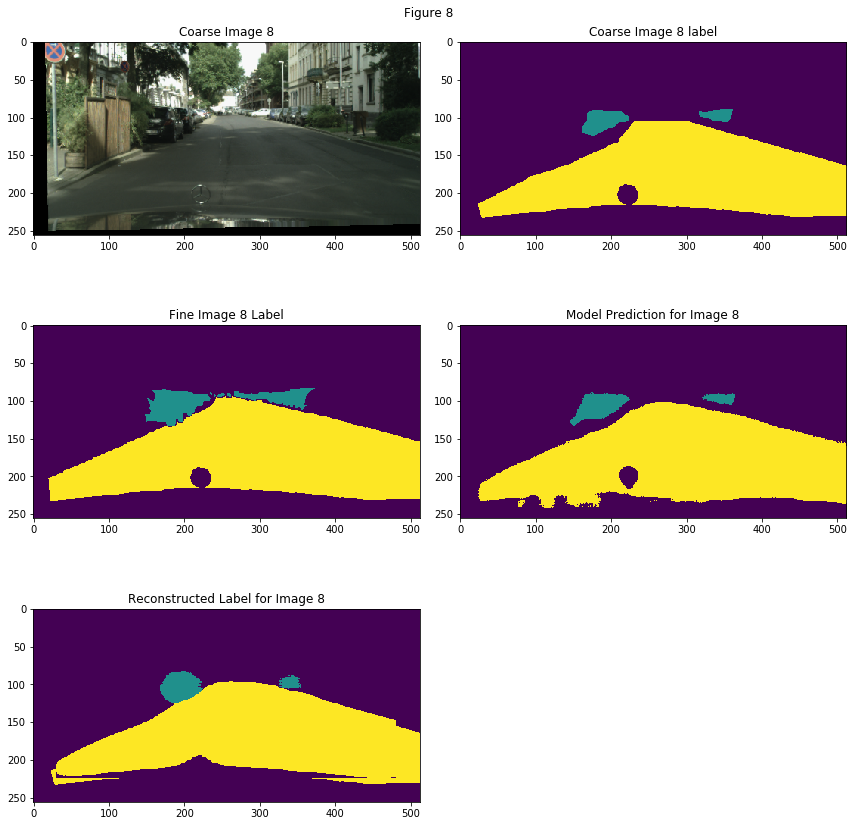

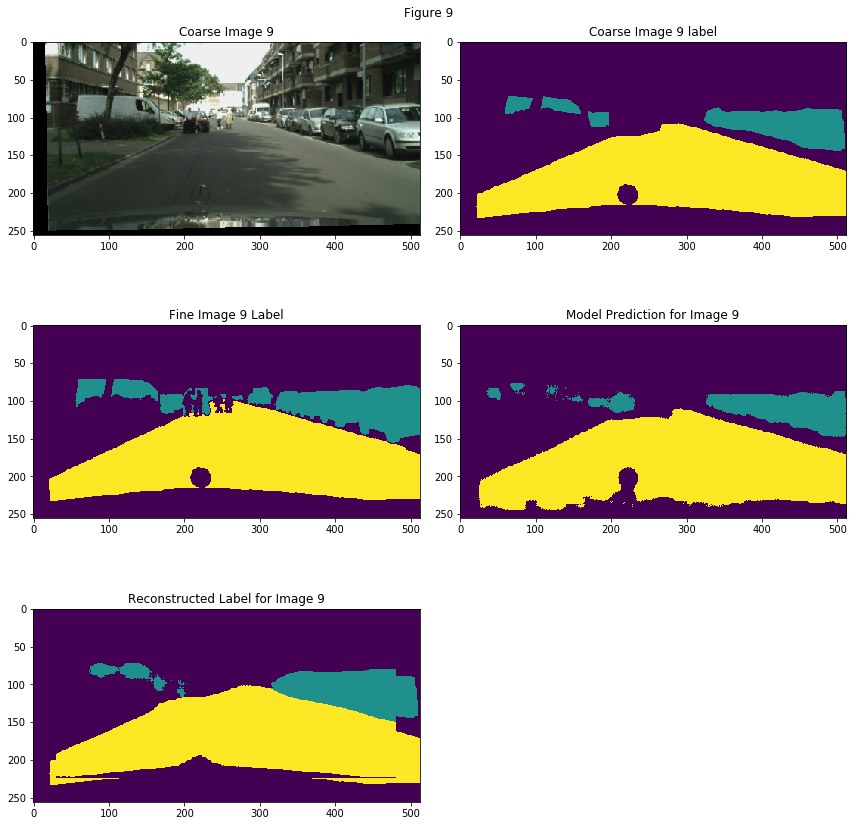

In [51]:
view_corrections_on_training_data(coarse_model, ec_model, n=10, ignore_pedestrians=ignore_pedestrians, 
                                  diff=False, use_model_pred=False, output_window_size=output_window_size, 
                                  input_window_size=input_window_size, use_x=True)